In [2]:
#basic
import pandas as pd
import numpy as np

#plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set(font_scale=1.3)
plt.style.use("fivethirtyeight")
%matplotlib inline
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# For reading stock data 
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

#modeling
import itertools
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit

np.random.seed(123)

In [3]:
df = DataReader('AAL', data_source='yahoo', start='2012-01-01', end=datetime.now())

In [4]:
data = df.filter(['Close'])

In [5]:
data

,Close
Date,
2012-01-03,5.120000
2012-01-04,5.030000
2012-01-05,5.470000
2012-01-06,5.600000
2012-01-09,5.720000
...,...
2021-09-02,19.760000
2021-09-03,19.370001
2021-09-07,19.530001


In [6]:
training_data_len = int(np.ceil(len(data) * .9 ))
train_data = data[0:int(training_data_len)]
test_data =data[int(training_data_len):]

In [7]:
train_data.shape

(2195, 1)

In [8]:
train_data

,Close
Date,
2012-01-03,5.12
2012-01-04,5.03
2012-01-05,5.47
2012-01-06,5.60
2012-01-09,5.72
...,...
2020-09-16,13.80
2020-09-17,13.63
2020-09-18,13.19


In [9]:
test_data.shape

(243, 1)

In [10]:
test_data

,Close
Date,
2020-09-23,11.930000
2020-09-24,11.770000
2020-09-25,12.290000
2020-09-28,12.760000
2020-09-29,12.250000
...,...
2021-09-02,19.760000
2021-09-03,19.370001
2021-09-07,19.530001


In [11]:
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets for s = 12 (constant)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [12]:
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

SARIMAX: (0, 0, 0) x (0, 0, 0, 12)
SARIMAX: (0, 0, 0) x (0, 0, 1, 12)
SARIMAX: (0, 0, 0) x (0, 1, 0, 12)
SARIMAX: (0, 0, 0) x (0, 1, 1, 12)
SARIMAX: (0, 0, 0) x (1, 0, 0, 12)
SARIMAX: (0, 0, 0) x (1, 0, 1, 12)
SARIMAX: (0, 0, 0) x (1, 1, 0, 12)
SARIMAX: (0, 0, 0) x (1, 1, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 0, 1) x (0, 1, 1, 12)
SARIMAX: (0, 0, 1) x (1, 0, 0, 12)
SARIMAX: (0, 0, 1) x (1, 0, 1, 12)
SARIMAX: (0, 0, 1) x (1, 1, 0, 12)
SARIMAX: (0, 0, 1) x (1, 1, 1, 12)
SARIMAX: (0, 1, 0) x (0, 0, 0, 12)
SARIMAX: (0, 1, 0) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
SARIMAX: (0, 1, 0) x (1, 0, 1, 12)
SARIMAX: (0, 1, 0) x (1, 1, 0, 12)
SARIMAX: (0, 1, 0) x (1, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 0, 0, 12)
SARIMAX: (0, 1, 1) x (0, 0, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x

In [13]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value

ans = []
for comb in pdq:
    for combs in seasonal_pdq:
        try:
            mod = SARIMAX(data,
                     order=comb,
                     seasonal_order=combs,
                     enforce_stationarity=False,
                     enforce_invertibility=False)                                    

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =24110.891740576073
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =20973.21742603393
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =12070.391370225201
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =12008.19598505467
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =12073.775716451139
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =12064.790114871124
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =12014.269250733185
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =12007.787526976668
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =20805.866657997536
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =17768.153168742305
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =9840.403370372316
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =9735.94845120402
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =12119.540448998912
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =9781.49952972756
ARIMA (0, 0, 

In [14]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
# Find the parameters with minimal AIC value
ans_df.loc[ans_df['aic'].idxmin()]
#output: pdq=(1, 1, 1) and pdqs= (1, 1, 1, 12)


pdq         (0, 1, 1)
pdqs    (0, 0, 1, 12)
aic        5875.12272
Name: 25, dtype: object

In [15]:
mod = SARIMAX(train_data, order=(0, 1, 1),seasonal_order=(0, 0, 1, 12),enforce_stationarity=False,enforce_invertibility=False)
                                                                
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 2195
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood               -2697.642
Date:                            Thu, 09 Sep 2021   AIC                           5401.285
Time:                                    18:04:38   BIC                           5418.346
Sample:                                         0   HQIC                          5407.522
                                           - 2195                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0676      0.018      3.756      0.000       0.032       0.103
ma.S.L12      -0.0076      0.018   

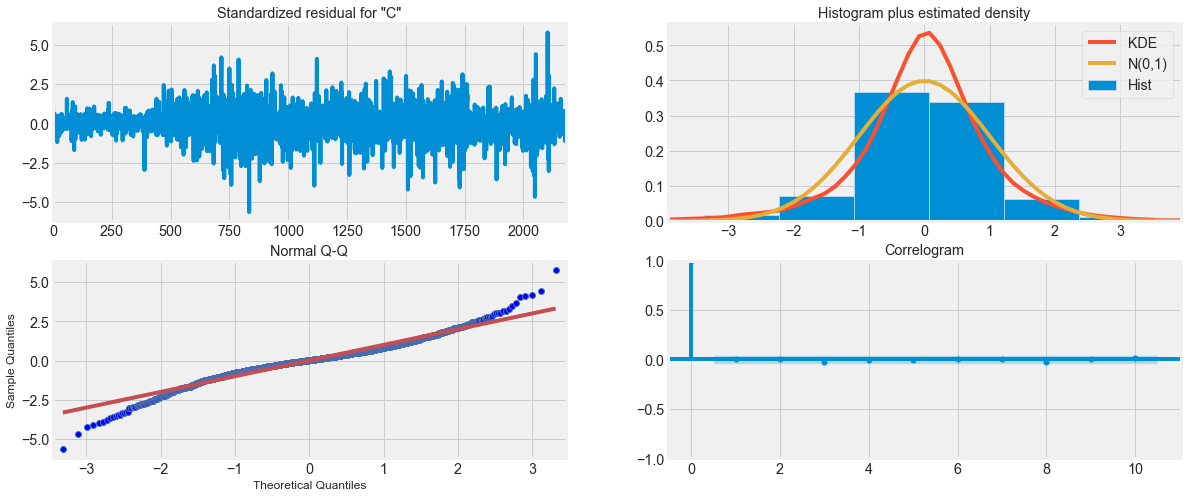

In [16]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [43]:
predictions= results.predict(start =training_data_len, end=training_data_len+len(test_data)+(steps)-1)

NameError: name 'train_size' is not defined

In [21]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-03'), dynamic=False)
pred_conf = pred.conf_int()

In [22]:
pred_conf

,lower Close,upper Close
Date,,
2020-01-03,27.477822,30.747127
2020-01-06,25.913797,29.183103
2020-01-07,25.672068,28.941374
2020-01-08,25.575363,28.844669
2020-01-09,26.244203,29.513509
...,...,...
2020-09-16,11.493726,14.763032
2020-09-17,12.214841,15.484147
2020-09-18,11.980133,15.249439


In [23]:
pred.predicted_mean.shape

(182,)

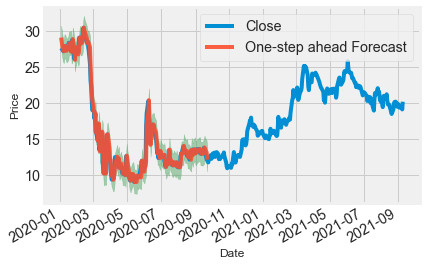

In [27]:
# Plot real vs predicted values along with confidence interval

# Plot observed values
ax = data['2020-01-03':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()

plt.show()

In [25]:
# Get the real and predicted values
forecasted = pred.predicted_mean
truth = data['2019-01-03':]

# Compute the mean square error
rmse = sqrt(mean_squared_error(truth,forecasted))
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

ValueError: Found input variables with inconsistent numbers of samples: [677, 182]

In [29]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2020-01-03'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

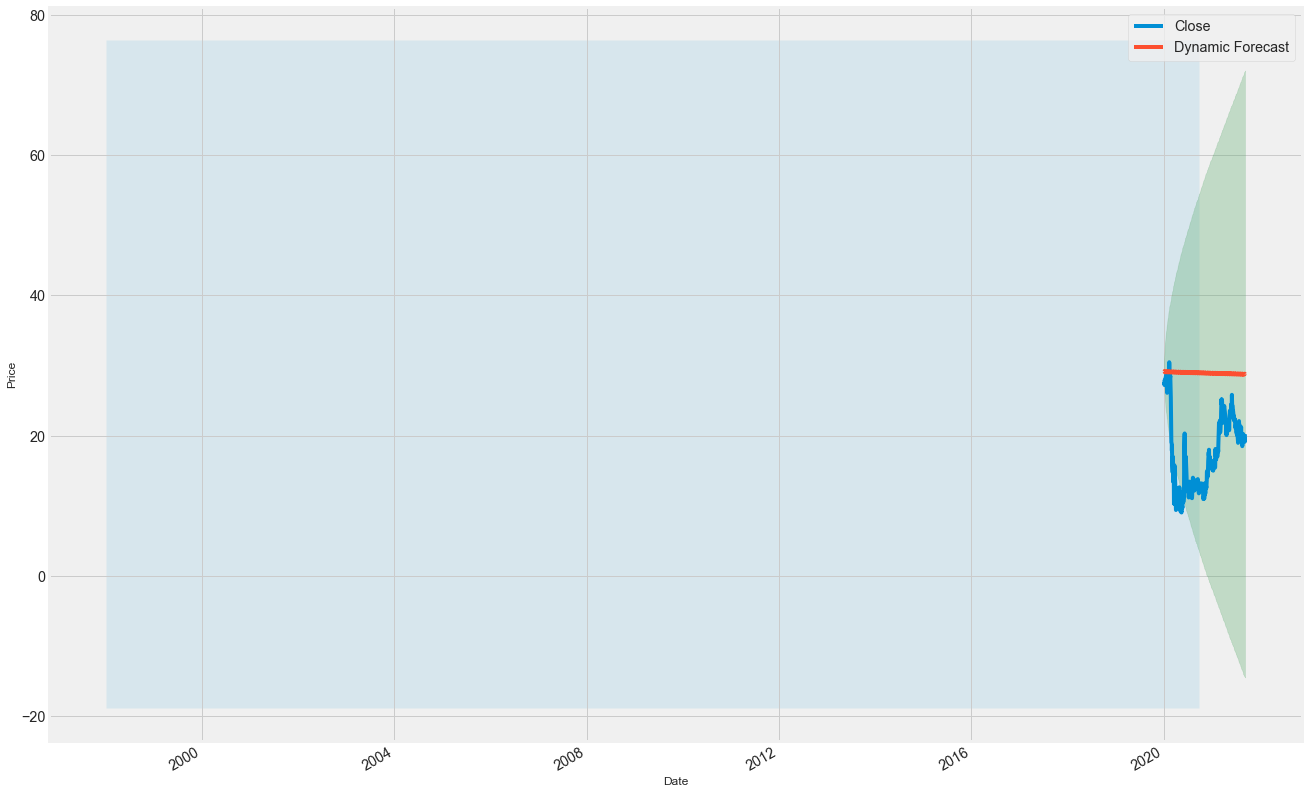

In [34]:
# Plot the dynamic forecast with confidence intervals.

ax = data['2020-01-03':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

In [35]:
# Extract the predicted and true values of our time series
forecasted_dy = pred_dynamic.predicted_mean
truth = data['2020-01-03':]

# Compute the mean square error
mse = ((forecasted_dy - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2020-01-03 00:00:00   NaN
2020-01-06 00:00:00   NaN
2020-01-07 00:00:00   NaN
2020-01-08 00:00:00   NaN
2020-01-09 00:00:00   NaN
                       ..
2021-09-03 00:00:00   NaN
2021-09-07 00:00:00   NaN
2021-09-08 00:00:00   NaN
2021-09-09 00:00:00   NaN
Close                 NaN
Length: 426, dtype: float64


In [36]:
# Get forecast 500 steps ahead in future
prediction = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()


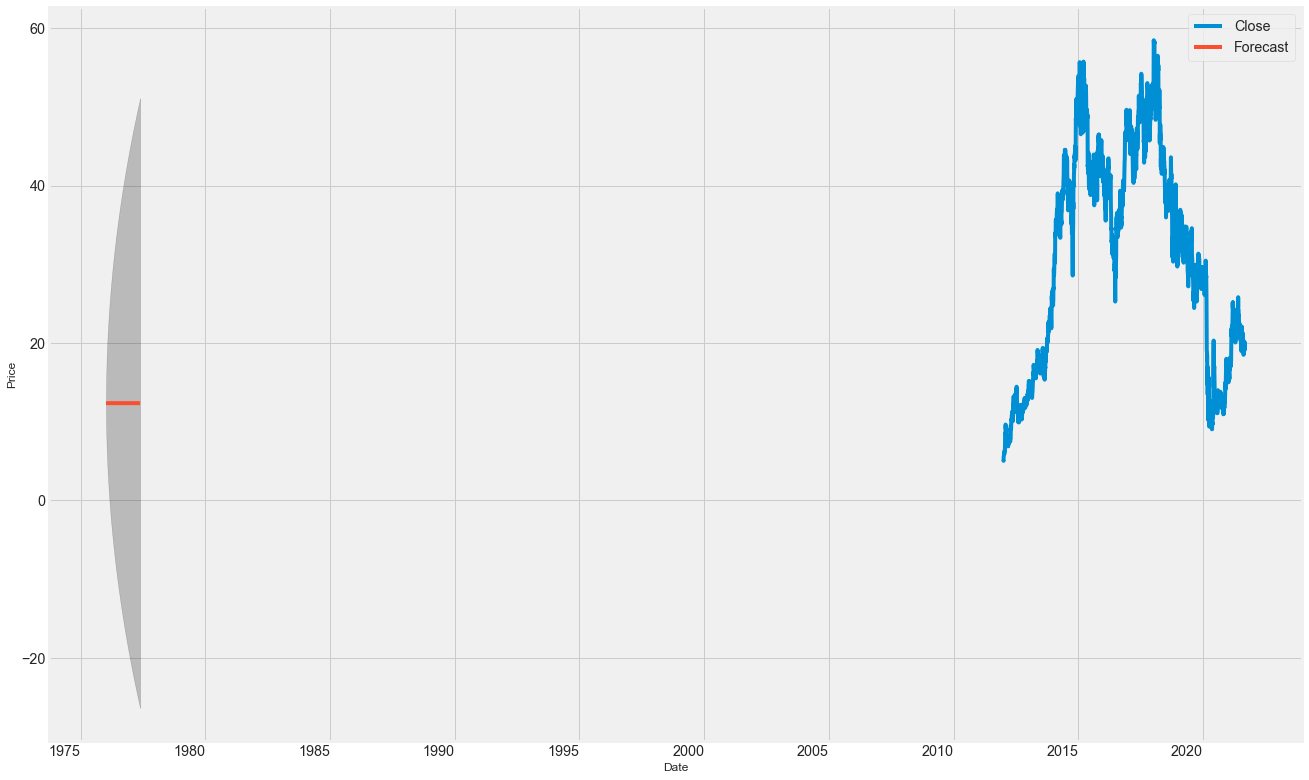

In [37]:
# Plot future predictions with confidence intervals
ax = data.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()